In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Yichao Chen
"""
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns



np.random.seed(1)

# global variables
epsilon = 0.9  # greedy police
alpha = 0.1  # learning rate
gamma = 0.9  # discount factor
niter = int(5*1e4)
NT = int(10)  # 10 periods
dt = 1  # send child order each dt
dT = 60  # decisions are made at each dT

kappa = 1  # second time scale
theta = 1
sigma = 0.02
phi = 0.02;
c = 100;

Qmax = 10;
Qmin = -10;
q_grid = list(range(Qmin, Qmax + 1))

a_grid = list(range(-5, 6))

s_min = theta - 5 * sigma / np.sqrt(2 * kappa)
s_max = theta + 5 * sigma / np.sqrt(2 * kappa)
Ns = 51;
ds = (s_max - s_min) / (Ns - 1);
s_grid = np.arange(s_min, s_max+ds/2, ds).tolist()


# initialize q table
def init_q_table(size_s, size_T, size_q, size_a):
    """
    Initialize q table.

    :param size_s: length of s_grid
    :param size_T: number of periods
    :param size_q: length of q_grid
    :param size_a: length of a_grid
    :type size_s: int
    :type size_T: int
    :type size_q: int
    :type size_a: int
    :return: q_table
    :rtype: numpy.ndarray
    """

    table = np.zeros([size_s, size_T + 1, size_q, size_a])
    print(table)
    return table


def init_state_matrices():
    s_matrix = np.zeros([niter, NT + 1])
    q_matrix = np.zeros([niter, NT + 1])
    a_matrix = np.zeros([niter, NT + 1])
    return s_matrix, q_matrix, a_matrix


def adms_actions(q):
    """
    Initialize q table.

    :param q: inventory
    :type q: int
    :return: admissible actions at inventory q
    :rtype: list
    """
    lowerbound = max(-5, -10 - q)
    upperbound = min(5, 10 - q)
    return list(range(lowerbound, upperbound + 1))


#
def get_action(s, T, q, q_table, epsilon):
    """
    return the epsilon_greedy action given a state

    :param s: spot price
    :param T: trading period
    :param q: inventory
    :type s: float
    :type T: int
    :type q: int
    :return: epsilon_greedy action
    :rtype: int
    """
    if (np.random.uniform() > epsilon):
        action = np.random.choice(adms_actions(q))
    else:
        adms_act_index = np.where(np.isin(a_grid, adms_actions(q)))[0]
        action_index_ = q_table[s_grid.index(s), T, q_grid.index(q), adms_act_index].argmax()
        action_index = adms_act_index[action_index_]
        action = a_grid[action_index]
    return action


def adms_actions(q):
    """
    return admissible actions at q

    :param q: inventory
    :type q: int
    :return: admissible actions
    :rtype: list
    """
    lowerbound = max(-5, -10 - q)
    upperbound = min(5, 10 - q)
    return list(range(lowerbound, upperbound + 1))


def adms_actions_indeces(q):
    """
    return the indices of admissible actions in a_grid

    :param q: inventory
    :type q: int
    :return: indices of admissible actions in a_grid
    :rtype: numpy.ndarray
    """
    return np.where(np.isin(a_grid, adms_actions(q)))[0]


def get_feedback(s, T, q, a):
    period_reward = 0
    for t in range(1, dT + 1):
        x = a / dT  # average order size per dt
        reward_, q, s = SimMRStep(s, q, x, kappa, theta, sigma, dt, phi)
        period_reward += reward_
    return s_grid[abs(s - np.array(s_grid)).argmin()], int(q), period_reward


def get_last_feedback(s, T, q, a):
    period_reward = 0
    for t in range(1, dT + 1):
        x = a / dT  # average order size per dt
        reward_, q, s = SimMRStep(s, q, x, kappa, theta, sigma, dt, phi)  # last period gets penalized by 10 times
        period_reward += reward_
    reward_, q_, s_ = SimMRStep(s, q, x, kappa, theta, sigma, dt, phi)
    terminal_reward = q * (s_- s) - c * phi * np.square(q_)
    period_reward += terminal_reward
    return s_grid[abs(s - np.array(s_grid)).argmin()], int(q), period_reward


def SimMRStep(S0, q0, x, kappa, theta, sigma, dt, phi):
    S1 = theta + (S0 - theta) * np.exp(-kappa * dt) + sigma * np.sqrt(dt) * np.random.randn();
    #S1 = S0 + kappa*(theta-S0)* dt + sigma * np.sqrt(dt) * np.random.randn()
    #x(i+1) = x(i)+th*(mu-x(i))*dt+sig*sqrt(dt)*randn
    q1 = q0 + x;
    #phi = 0;
    reward = q1 * (S1 - S0) - phi * np.square(x);
    return reward, q1, S1


# define epsilon-greedy q learning for optimal execution

def q_learning():
    s_matrix, q_matrix, a_matrix = init_state_matrices()
    q_table = init_q_table(len(s_grid), NT, len(q_grid), len(a_grid))
    for episode in range(int(niter)):
        #print('episode'+ str(episode))
        epsilon = 1 - 1 /(1 + episode)  # greedy police
        alpha = 1 /(1 + episode)
        T = 0
        s = np.random.choice(s_grid)
        q = np.random.choice(q_grid)
        while T < NT - 1:
            a = get_action(s, T, q, q_table, epsilon)  # choose epsilon-greedy action
            s_, q_, r = get_feedback(s, T, q, a)  # get next state and the current reward
            q_predict = q_table[s_grid.index(s), T, q_grid.index(q), a_grid.index(a)]  # get Q(s,T,q,a)
            q_target = r + gamma * q_table[s_grid.index(s_), T + 1, q_grid.index(q_), adms_actions_indeces(
                q_)].max()  # r+gamma*argmax_{a'} Q(s_,T+1,q_,a')
            q_table[s_grid.index(s), T, q_grid.index(q), a_grid.index(a)] += alpha * (q_target - q_predict)
            # Q(s,T,q,a)<- Q(s,T,q,a)- alpha*Q(s,T,q,a)+ alpha*(r+gamma*argmax_{a'} Q(s_,T+1,q_,a'))

            # store the states and actions
            s_matrix[episode, T] = s
            q_matrix[episode, T] = q
            a_matrix[episode, T] = a
            s = s_
            q = q_
            T += 1

        # update last period with different feedback
        a = get_action(s, T, q, q_table, epsilon)
        s_, q_, r = get_last_feedback(s, T, q, a)
        q_predict = q_table[s_grid.index(s), T, q_grid.index(q), a_grid.index(a)]
        q_target = r + gamma * q_table[s_grid.index(s_), T + 1, q_grid.index(q_), adms_actions_indeces(q_)].max()
        q_table[s_grid.index(s), T, q_grid.index(q), a_grid.index(a)] += alpha * (q_target - q_predict)

        s_matrix[episode, T] = s
        q_matrix[episode, T] = q
        a_matrix[episode, T] = a
        s_matrix[episode, T + 1] = s_
        q_matrix[episode, T + 1] = q_

        # s = s_
        # q = q_
    return q_table, s_matrix, q_matrix, a_matrix

def get_optimal_actions(T):
    optimal_action_table = np.zeros([len(s_grid),len(q_grid)])
    for i in range (np.shape(q_table)[0]):
        for j in range (np.shape(q_table)[2]):
            optimal_action_table[i,j]= a_grid[np.argmax(q_table[:,T,:,:],axis=-1)[i,j]]
    return pd.DataFrame(optimal_action_table, columns = q_grid, index=s_grid)


def plot_actions(T):
    # Get a data set of optimal actions for pairs (inventory,price)
    # At a fixed time
    # Generate sample data
    # Columns are x axis (inventory) and rows are y axis (price)

    cmap = sns.diverging_palette(20, 240, as_cmap=True)  # husl color system
    heat_map = sns.heatmap(get_optimal_actions(T), cmap=cmap)
    plt.xlabel("Inventory")
    plt.ylabel("Price")
    plt.show()



if __name__ == '__main__':
    q_table, s_matrix, q_matrix, a_matrix = q_learning()
    plt.hist(q_matrix[:-1,-1])
    plt.xlabel("frequency")
    plt.ylabel("terminal inventory")

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  ...

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 

The best actions are balancing the inventory and the immediate reward of selling/buying

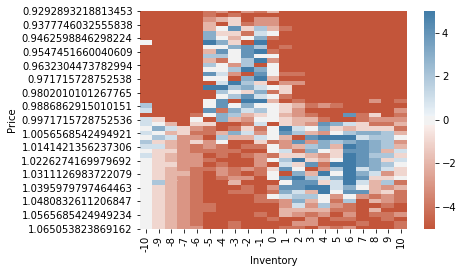

In [2]:
plot_actions(3)

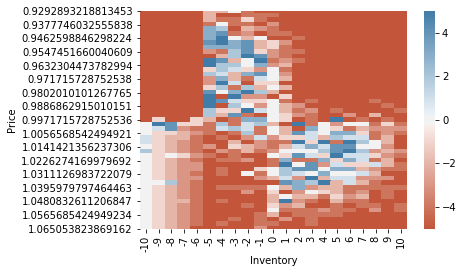

In [3]:
plot_actions(5)

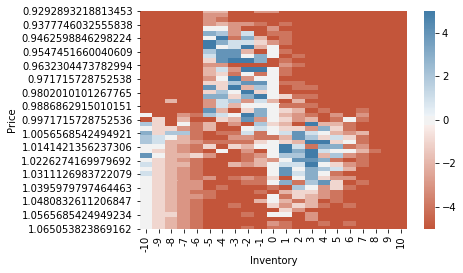

In [4]:
plot_actions(7)

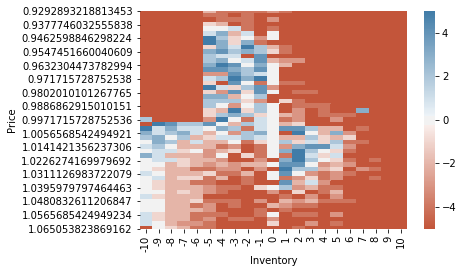

In [5]:
plot_actions(8)

The best action for the last period is always the action that makes 0 terminal inventory

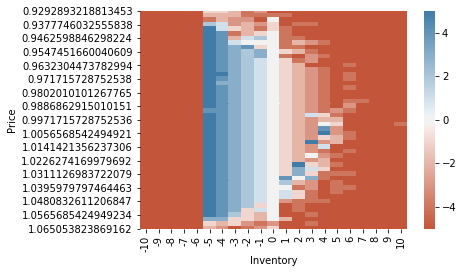

In [6]:
plot_actions(9)

Text(0.5, 0, 'terminal inventory')

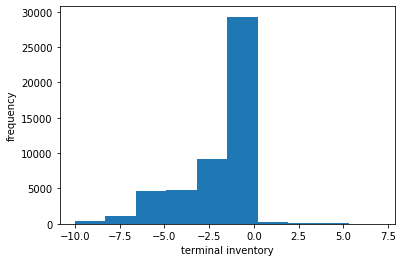

In [7]:
    plt.hist(q_matrix[:-1,-1])
    plt.ylabel("frequency")
    plt.xlabel("terminal inventory")

Text(0.5, 0, 'terminal inventory')

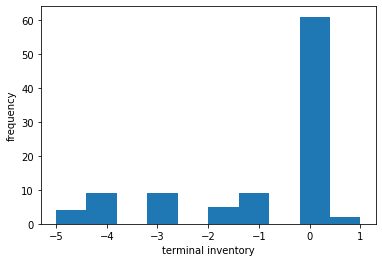

In [8]:
    plt.hist(q_matrix[-100:-1,-1])
    plt.ylabel("frequency")
    plt.xlabel("terminal inventory")